# Телеком, прогнозирование ухода клиентов.

## Описание задачи
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

contract.csv — информация о договоре;

personal.csv — персональные данные клиента;

internet.csv — информация об интернет-услугах;

phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.



Данные также находятся в тренажёре, в папке /datasets/final_provider/.

### Описание полей данных:

Оператор предоставляет два основных типа услуг:

Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);

Выделенная линия технической поддержки (TechSupport);

Облачное хранилище файлов для резервного копирования данных (OnlineBackup);

Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

***Описание полей данных:***

**contract.csv**
- customerID - ID клиента
- BeginDate – дата начала пользования услугами
- EndDate – дата окончания пользования услугами
- Type – тип оплаты: ежемесячный, годовой и тд
- PaperlessBilling – безналичный расчет
- PaymentMethod – способ оплаты
- MonthlyCharges – ежемесячные траты на услуги
- TotalCharges – всего потрачено денег на услуги

**internet.csv**

- customerID - ID клиента
- InternetService - тип подключения интернета
- OnlineSecurity - услуга блокировки небезопасных сайтов
- OnlineBackup - облачное хранилище файлов для резервного копирования данных
- DeviceProtection - услуга антивирус
- TechSupport - услуга Выделенная линия технической поддержки
- StreamingTV - услуга Стриминговое телевидение
- StreamingMovies - услуга каталог фильмов 

**personal.csv**
- customerID - ID клиента
- gender - пол клиента
- SeniorCitizen – наличие пенсионного статуса по возрасту 
- Partner – наличие супруга(и)
- Dependents – наличие иждивенцев 
 
**phone.csv**
- customerID - ID клиента
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

## План решения задачи

1. Загрузка данных, знакомство с данными.

2. Предобработка данных.
    Обработка данных от пропусков, дубликатов, изменение типов и тд.
    
3. Анализ данных.
    Исследование данных, выявление корреляций, закономерностей, выбросов и тд.
    
4. Реализация модели.
    Разделение данных на обучающий, валидационный, тестовый сеты, стандартизация данных, устранение дисбаланса данных и тд.
    Выбор метрики оценки качества модели, подбор разных моделей, обучение, проверка.
   
5. Анализ результатов. 
    Выбор наилучшей модели. Анализ остатков, выводы.

## Загрузка данных, знакомство с данными

In [1]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# импорты модулей
import lightgbm as lgb
from matplotlib import pyplot as plt
import numpy as np
import optuna
import pandas as pd
import scipy as sc
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle

SEED = 54321

In [3]:
# создадим функцию загрузки фреймов
def file_open(link, name_list, df_dates=None, parse_dates=0): # оптсываем путь, имена файлов, распознание дат при загрузке
    output_df = []
    for i in range(len(name_list)):
        if name_list[i] == df_dates:
            try:
                df = pd.read_csv(link[1]+name_list[i], parse_dates=parse_dates)
            except:
                df = pd.read_csv(link[0]+name_list[i])
        else:
            try:
                df = pd.read_csv(link[1]+name_list[i])
            except:
                df = pd.read_csv(link[0]+name_list[i])
        output_df.append(df)
    return output_df[:]
        

In [4]:
frame_list = ['contract.csv', 'personal.csv', 'internet.csv', 'phone.csv']
link = ['/datasets/final_provider/', r'C:\Users\EliteBook\Downloads\\']

# загружаем фреймы в переменные через функцию
contract, personal, internet, phone = file_open(
    link=link, name_list=frame_list,
    df_dates='contract.csv', parse_dates=[1,2])

list_telecom = [contract, internet, personal, phone]
# цикл просмотра данных их фреймов для знакомства
for df in list_telecom:
    print(f'''{df.info()},
    
    Первые 5 строк :''')
    display(df.head())
    print('')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        7043 non-null   int64         
 1   customerID        7043 non-null   object        
 2   BeginDate         7043 non-null   datetime64[ns]
 3   EndDate           7043 non-null   object        
 4   Type              7043 non-null   object        
 5   PaperlessBilling  7043 non-null   object        
 6   PaymentMethod     7043 non-null   object        
 7   MonthlyCharges    7043 non-null   float64       
 8   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 495.3+ KB
None,
    
    Первые 5 строк :


,Unnamed: 0,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     7043 non-null   int64 
 1   customerID     7043 non-null   object
 2   gender         7043 non-null   object
 3   SeniorCitizen  7043 non-null   int64 
 4   Partner        7043 non-null   object
 5   Dependents     7043 non-null   object
dtypes: int64(2), object(4)
memory usage: 330.3+ KB
None,
    
    Первые 5 строк :


,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents
0,0,7590-VHVEG,Female,0,Yes,No
1,1,5575-GNVDE,Male,0,No,No
2,2,3668-QPYBK,Male,0,No,No
3,3,7795-CFOCW,Male,0,No,No
4,4,9237-HQITU,Female,0,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        5517 non-null   int64 
 1   customerID        5517 non-null   object
 2   InternetService   5517 non-null   object
 3   OnlineSecurity    5517 non-null   object
 4   OnlineBackup      5517 non-null   object
 5   DeviceProtection  5517 non-null   object
 6   TechSupport       5517 non-null   object
 7   StreamingTV       5517 non-null   object
 8   StreamingMovies   5517 non-null   object
dtypes: int64(1), object(8)
memory usage: 388.0+ KB
None,
    
    Первые 5 строк :


,Unnamed: 0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,4,9237-HQITU,Fiber optic,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     6361 non-null   int64 
 1   customerID     6361 non-null   object
 2   MultipleLines  6361 non-null   object
dtypes: int64(1), object(2)
memory usage: 149.2+ KB
None,
    
    Первые 5 строк :


,Unnamed: 0,customerID,MultipleLines
0,0,5575-GNVDE,No
1,1,3668-QPYBK,No
2,2,9237-HQITU,No
3,3,9305-CDSKC,Yes
4,4,1452-KIOVK,Yes


In [5]:
# объединим данные в единый фрейм
df_full = contract.drop('Unnamed: 0',axis=1)
for i in range(1, len(list_telecom)):
    list_telecom[i]=list_telecom[i].drop('Unnamed: 0',axis=1)
    df_full = df_full.merge(list_telecom[i], on='customerID', how='outer')

In [6]:
# просмотр информации объединенных данных и уникальные значение для столбцов для знакомства
df_full.info()
uniq_val=pd.DataFrame()
for col in df_full.columns:
    uniq_val[col] = pd.Series(df_full[col].unique())
display(uniq_val.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0.0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2019-12-01 00:00:00,One year,No,Mailed check,56.95,1889.5,Male,1.0,No,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No
2,3668-QPYBK,2019-10-01,2019-11-01 00:00:00,Two year,NaN,Bank transfer (automatic),53.85,108.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
3,7795-CFOCW,2016-05-01,2019-10-01 00:00:00,NaN,NaN,Credit card (automatic),42.30,1840.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9237-HQITU,2019-09-01,2020-01-01 00:00:00,NaN,NaN,NaN,70.70,151.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# проверим данные на дубликаты и на пропущенные данные
print('Количество дубликатов', df_full.duplicated().sum())
print(df_full.isna().sum())

Количество дубликатов 0
customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


*** Вывод**

После общего ревью данных видно, что требуется предобработка данных, анализ данных, заполнение пропусков, добавление столбцов длительности контракта, целевой признак пребразовать в столбец  из EndDate, преобразование данных из категориальных в численные, дальнейшее внедрение модели.

## Предобработка данных

In [8]:
# создаем столбец целевого значения
df_full['LostClient'] = df_full['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

In [9]:
# делаем заглушку в столбце EndDate, переводим данные в тип времени, вычисляем длительность контрактов, переводим в числовое значение
df_full['EndDate'] = df_full['EndDate'].where((df_full['EndDate'] != 'No'), '2020-02-01')
df_full['BeginDate'] = pd.to_datetime(df_full['BeginDate'], format='%Y-%m-%d')
df_full['EndDate'] = pd.to_datetime(df_full['EndDate'], format='%Y-%m-%d')
df_full['ContractDuration'] = df_full['EndDate'] - df_full['BeginDate']
df_full['ContractDuration'] = pd.to_numeric(df_full['ContractDuration'].dt.days)

In [10]:
df_full

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,LostClient,ContractDuration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,DSL,No,Yes,No,No,No,No,NaN,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,No,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.5,Male,0,...,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0,730
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0,2191
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,...,DSL,Yes,No,No,No,No,No,NaN,0,337
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.6,Male,1,...,Fiber optic,No,No,No,No,No,No,Yes,1,123


In [11]:
# удаляем столбцы дат и ID чтобы не допустить утечки данных и для упрощения обработки данных
df_full = df_full.drop(['customerID','BeginDate','EndDate'], axis=1)

In [12]:
# Заполним пропуски в услуге пользования интернетом на No, т.к. вероятно отсутствие значений для ряда клиентов по Интернету
# означает отсутствие подключения и нтернета.
columns = df_full.columns[df_full.isna().any()].tolist()
#columns.remove('MultipleLines')
df_full[columns] = df_full[columns].fillna('No')

In [13]:
df_full.head(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,LostClient,ContractDuration
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,61


In [14]:
# преобразуем данные в столбцах в числовое значение через Ordinal Encoder, так как использовать будем модели классификации
enc = OrdinalEncoder()
label = df_full.columns.tolist()
df_full = pd.DataFrame(enc.fit_transform(df_full), columns = label)


In [15]:
df_full.dtypes

Type                float64
PaperlessBilling    float64
PaymentMethod       float64
MonthlyCharges      float64
TotalCharges        float64
gender              float64
SeniorCitizen       float64
Partner             float64
Dependents          float64
InternetService     float64
OnlineSecurity      float64
OnlineBackup        float64
DeviceProtection    float64
TechSupport         float64
StreamingTV         float64
StreamingMovies     float64
MultipleLines       float64
LostClient          float64
ContractDuration    float64
dtype: object

 создадим функцию замены пропусков с помощью модели Случайного леса решений
def autofill(data, target):
    colum = data.columns[df_full.isna().any()].tolist() # названия столбцов с пропусками
    
    data_c = data.dropna(axis=0) # очищенные от пропусков данные для обучения
    rfc = RandomForestClassifier(random_state=SEED)

    param = {'n_estimators':[50,150],
             'max_depth':[20,100,3],
             'min_samples_split':[2,14],
             'min_samples_leaf':[1,10]}
    
    for i in range(len(colum)): # цикл поочередного заполнения пропусков по столбцам
        for_pred = data[data[colum[i]].isna() == True]
        for_pred = for_pred.dropna(axis=1) # признаки для предсказания, очищенные от пропусков
        for_pred = for_pred.drop(target, axis=1) # удаляем таргет исследования для недопущения утечки данных
        col = for_pred.columns.tolist() # итоговый список столбцов признаков для обучения
        
        c_feat = data_c[col]
        c_target = data_c[colum[i]]
        
        clf = GridSearchCV(rfc, param_grid=param, scoring='f1') # используем подбор параметров с кросс-валидацией
                                                                # оцениваем точность по F1
        clf.fit(c_feat,c_target)
        
        print('F1 метрика заполнения пропусков для колонки '+str(colum), clf.best_score_)
        
        pred = clf.predict(for_pred)
        data.loc[(data[colum[i]].isna() == True), colum[i]] = pred
    return data

In [16]:
df_full.info() # посмотрим данные после обработки пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   float64
 1   PaperlessBilling  7043 non-null   float64
 2   PaymentMethod     7043 non-null   float64
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   float64
 6   SeniorCitizen     7043 non-null   float64
 7   Partner           7043 non-null   float64
 8   Dependents        7043 non-null   float64
 9   InternetService   7043 non-null   float64
 10  OnlineSecurity    7043 non-null   float64
 11  OnlineBackup      7043 non-null   float64
 12  DeviceProtection  7043 non-null   float64
 13  TechSupport       7043 non-null   float64
 14  StreamingTV       7043 non-null   float64
 15  StreamingMovies   7043 non-null   float64
 16  MultipleLines     7043 non-null   float64


### Вывод
Объединил данные, пропуски в пользовании интернет услугами принимаем как отсутствие подключения интернета у данных клиентов. Пропуски в пользовании многоканальным телефоном заполнил с помощью RandomForestClassifier.

Добавил таргетное поле, сгенерировал признак длительности контракта, удалил столбцы дат чтобы недопустить утечки данных, удалил ноиера клиентов. С точки зрения теории данных поле длительности контракта несет минимальную утечку данных, но восстановить даты из данного поля невозможно и задача модели прогнозировать вероятный уход текущих клиентов в дальнейшем, в связи с этим пользоваться данным полем возможно.

## Анализ данных

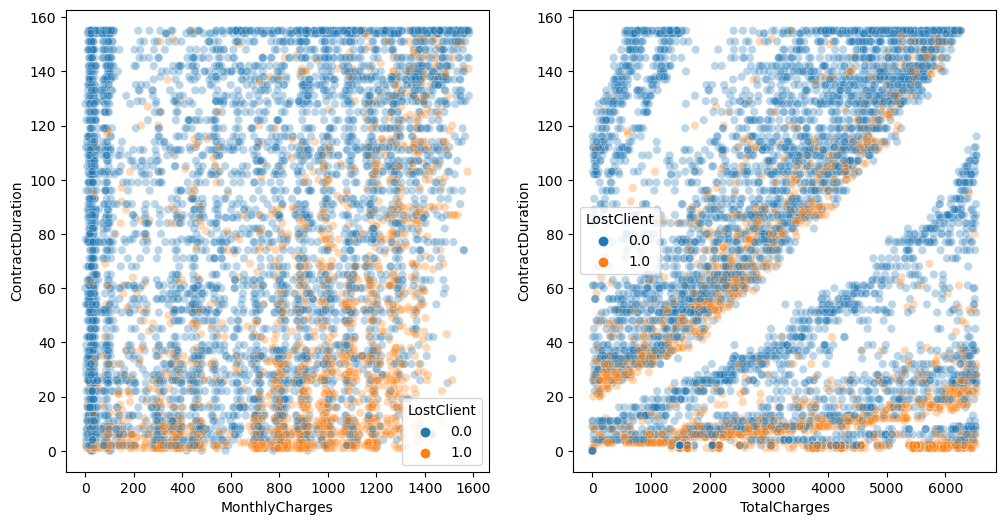

In [17]:
# отдельно выведем корреляции длительности контракта и месячной и накопительной оплаты
plot_list = ['MonthlyCharges', 'TotalCharges']
fig = plt.figure(figsize=(12,6))
for i in range(2):
    fig.add_subplot(1, 2, i+1)
    sns.scatterplot(data=df_full, x=plot_list[i], y='ContractDuration', hue='LostClient', alpha=0.3)
plt.show()


Видна корреляция уходящих клиентов с велечиной помесячной оплаты, так же видна корреляция в накопительной сумме оплаченного и ухода клиентов, неравномерность распределения клиентов в данном графике вероятна связана с тарифными планами, которых, похоже, три , заметно, что уходящие клиенты группируются в области оплаты выше тарифа, но ниже следующего по велечине платы тарифа, что логично, т.к. текущий тариф уходящих клиентов не устраивает по ресурсам, клиент выходит за рамки включенного в тариф, а следующий тариф слишком дорог.

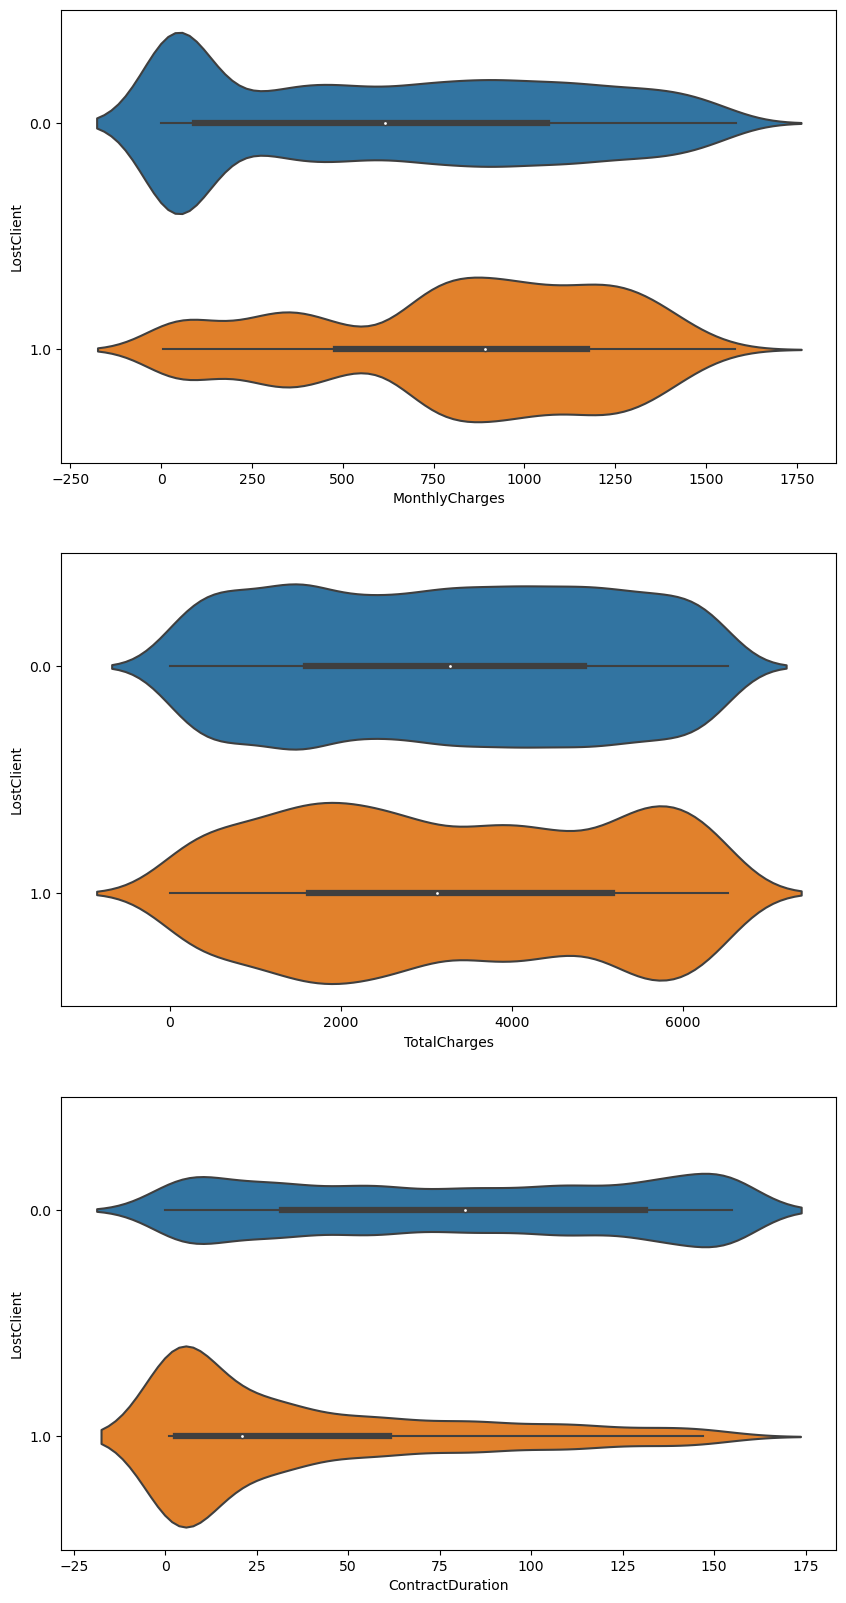

In [18]:
# выведем данные по распределению клиентов в зависимости от велечены платы месячной, накопительной и длительности контракта
plot_list = ['MonthlyCharges', 'TotalCharges', 'ContractDuration']
fig = plt.figure(figsize=(10,20))
for i in range(3):
    fig.add_subplot(3, 1, i+1)
    sns.violinplot(data=df_full, orient='h', x=plot_list[i],  y='LostClient', inner='box')
plt.show()

### Вывод

Провёл нанализ данных, за скобками оставил наблюдение, что от 2014 года к текущему моменту
произошло изменение в распределении типа договора от оплаты за два года и за год к помесячной оплате,
что согласуется с корреляцией количества уходящих клиентов от срока контракта.

Так же выборка велась не постоянно, все уходы клиентов находятся во временном промежутке последних 4 месяцев.

Наиболее заметные корреляции между уходом клиента и признаком отмечу по длительности контракта, по месячному плтежу и сумме платежей.


## Реализация модели.

In [19]:
df_X = df_full.drop('LostClient', axis=1)
df_y = df_full['LostClient']

In [20]:
def upsample(features, target, repeat): # Балансировка классов
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=SEED)
    
    return features_upsampled, target_upsampled

Написал функцию для ручной балансировки классов в тренинговой выборке, с ручной балансировкой результат лучше, хотя растет количество FP предсказаний, но улучшение TP выше, применение оправдано.

In [21]:
train_X, test_X, train_y, test_y = train_test_split(df_X, df_y, test_size = 0.25, random_state = SEED)

print('Баланс классов в обучающей выборке = ',train_y[train_y == 0].count()/train_y[train_y == 1].count())

train_X, train_y = upsample(train_X, train_y, 2)

print('Баланс классов в обучающей выборке после ресемплирования = ', train_y[train_y == 0].count()/train_y[train_y == 1].count())

Баланс классов в обучающей выборке =  2.8386627906976742
Баланс классов в обучающей выборке после ресемплирования =  1.4193313953488371


In [22]:
# случайный лес решений
rfc = RandomForestClassifier(random_state=SEED)
param = {'n_estimators':[50,150],
             'max_depth':[20,100,3],
             'min_samples_split':[2,14],
             'min_samples_leaf':[1,10]}
clf = GridSearchCV(rfc, param_grid=param, scoring='roc_auc')
clf.fit(train_X, train_y)
print('AUC-ROC метрика на обучающей выборке: ',clf.best_score_)

print('AUC-ROC метрика на тестовой выборке: ',roc_auc_score(test_y, clf.predict_proba(test_X)[:, 1]))

AUC-ROC метрика на обучающей выборке:  0.9574711738580477
AUC-ROC метрика на тестовой выборке:  0.8466560234449485


In [23]:
def confus_matrix(y,pred): # функция печати матрицы неточностей
    conf_matrix = pd.DataFrame(confusion_matrix(y, pred), columns=['Negative', 'Positive'])
    conf_matrix['TF'] = ['True-False', 'False-True']
    display(conf_matrix.set_index('TF'))

In [24]:
def roc_curve_plot(y, pred, name_model): # Функция печати кривой AUC
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name=name_model)
    display.plot()
    plt.show()

In [25]:
confus_matrix(y=test_y, pred=clf.predict(test_X))

,Negative,Positive
TF,,
True-False,1127,141
False-True,201,292


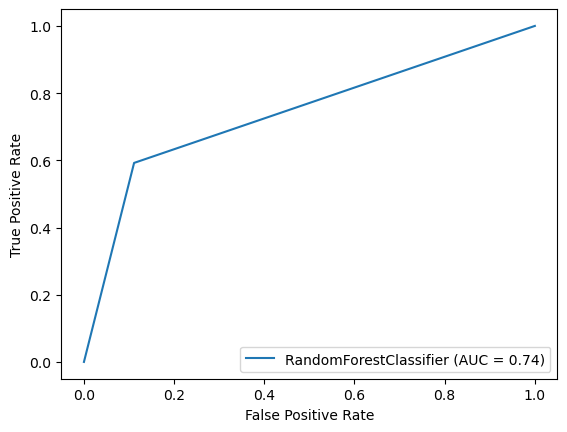

In [26]:
roc_curve_plot(y=test_y, pred=clf.predict(test_X), name_model='RandomForestClassifier')

In [27]:
# Модель LGBMClassifier
model_boost = lgb.LGBMClassifier(metric='auc', n_estimators=15000, learning_rate=0.001)
model_boost.fit(train_X, train_y)
print('AUC-ROC метрика на обучающей выборке: ',roc_auc_score(train_y, model_boost.predict_proba(train_X)[:, 1]))
print('AUC-ROC метрика на тестовой выборке: ',roc_auc_score(test_y, model_boost.predict_proba(test_X)[:, 1]))

AUC-ROC метрика на обучающей выборке:  0.9920740043641864
AUC-ROC метрика на тестовой выборке:  0.8960270282375977


In [28]:
confus_matrix(y=test_y, pred=model_boost.predict(test_X))


,Negative,Positive
TF,,
True-False,1126,142
False-True,138,355


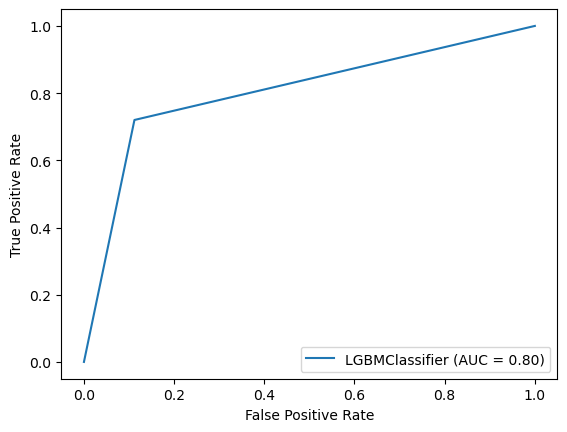

In [29]:
roc_curve_plot(y=test_y, pred=model_boost.predict(test_X), name_model='LGBMClassifier')

In [30]:
# Подбор параметров модели в Optuna
def objective(trial, data=df_X, target=df_y):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=SEED-1234)
    X_train, y_train = upsample(X_train, y_train, 2)
                                                        
    params = { 
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.65,0.7,0.75,0.8,0.85]),
        'learning_rate': trial.suggest_categorical('learning_rate',[0.001,0.002,0.003,0.004,0.006,0.008,0.01,0.015]), 
        'max_depth': trial.suggest_categorical('max_depth', [-1,10,30]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 300),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'min_child_samples' : trial.suggest_int('min_child_samples', 1, 60)
    }
    
    model = lgb.LGBMClassifier(**params, metric='auc', n_estimators=20000,
                              random_state=SEED)
    callbacks = [lgb.early_stopping(300, verbose=0), lgb.log_evaluation(period=0)]
    
    # Обучаем модель      
    model.fit(X_train, y_train, eval_set=[(X_test,y_test)], callbacks=callbacks)
    preds = model.predict_proba(X_test)[:, 1]
    
    metric = roc_auc_score(y_test, preds)
    
    return metric


In [31]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='maximize')  # Минимизируем ошибку
study.optimize(objective, n_trials=15)  

[I 2022-11-01 11:37:22,066] A new study created in memory with name: no-name-40300b05-cb0c-48a8-8f26-29f63580f8df
C:\Users\EliteBook\AppData\Local\Temp\ipykernel_15040\798200921.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\EliteBook\AppData\Local\Temp\ipykernel_15040\798200921.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\EliteBook\AppData\Local\Temp\ipykernel_15040\798200921.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

In [32]:
optuna_params = study.best_params # Сохраняем подобранные параметры

optuna_params['metric'] = 'auc' # Добавляем метрику
optuna_params['random_state'] = SEED
optuna_params['n_estimators'] = 20000

In [33]:
# запускаем модель с подобранными параметрами
model_lgbm_optuna = lgb.LGBMClassifier(**optuna_params)
callbacks = [lgb.early_stopping(300, verbose=0), lgb.log_evaluation(period=0)]
model_lgbm_optuna.fit(train_X, train_y, eval_set=[(test_X, test_y)], callbacks=callbacks)

print('AUC-ROC метрика на обучающей выборке: ',roc_auc_score(train_y, model_lgbm_optuna.predict_proba(train_X)[:, 1]))
print('AUC-ROC метрика на тестовой выборке: ',roc_auc_score(test_y, model_lgbm_optuna.predict_proba(test_X)[:, 1]))

AUC-ROC метрика на обучающей выборке:  0.9897308776598912
AUC-ROC метрика на тестовой выборке:  0.9135659485158145


In [34]:
confus_matrix(y=test_y, pred=model_lgbm_optuna.predict(test_X))

,Negative,Positive
TF,,
True-False,1133,135
False-True,126,367


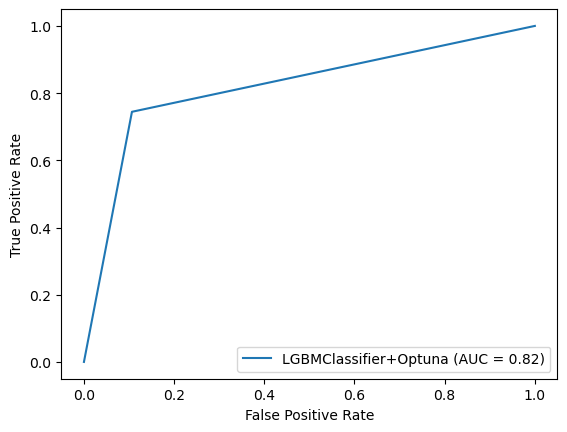

In [35]:
roc_curve_plot(y=test_y, pred=model_lgbm_optuna.predict(test_X), name_model='LGBMClassifier+Optuna')

## Анализ результатов.

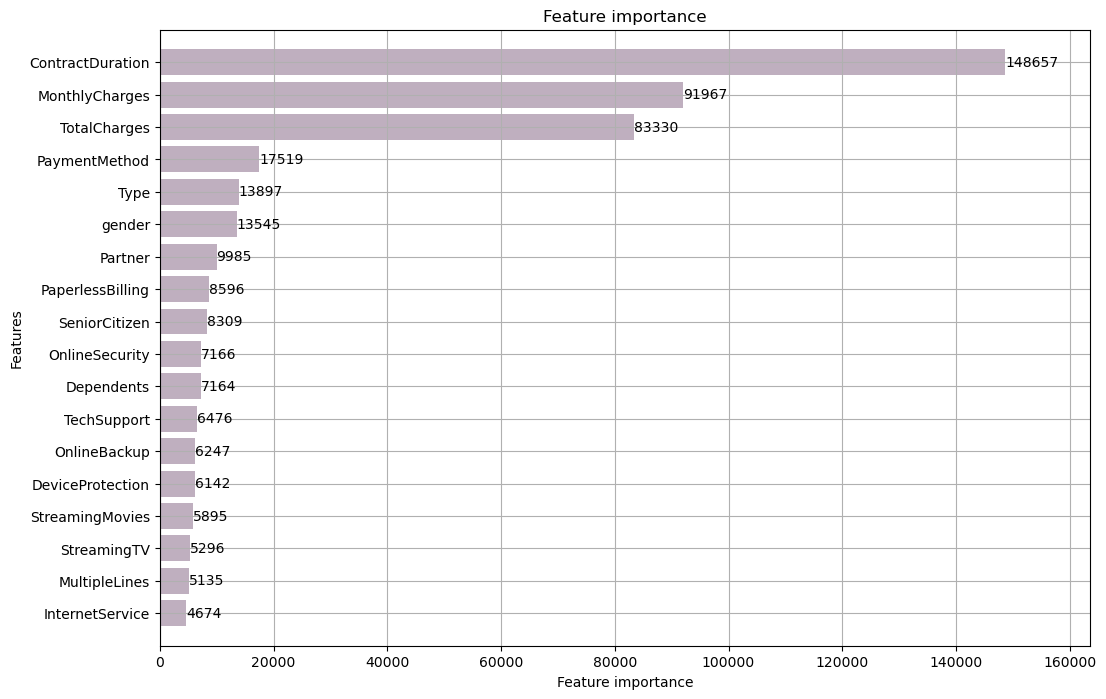

In [36]:
lgb.plot_importance(model_boost,height=0.8,figsize=(12,8),color='#BFAFBF')
plt.show()

In [37]:
confus_matrix(y=test_y, pred=model_boost.predict(test_X))


,Negative,Positive
TF,,
True-False,1126,142
False-True,138,355


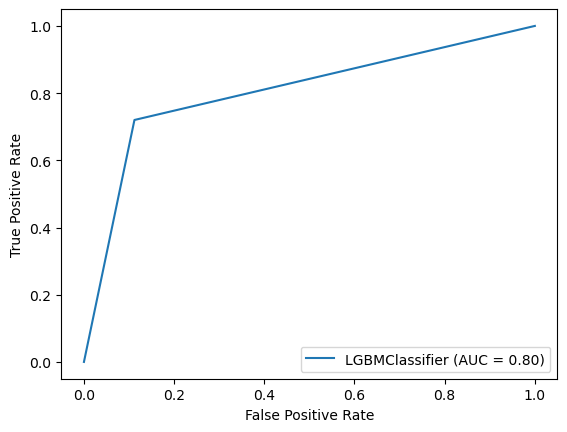

In [38]:
roc_curve_plot(y=test_y, pred=model_boost.predict(test_X), name_model='LGBMClassifier')

Из рассмотренных моделей наилучшее сочетание показателя метрики ROC-AUC и скорости работы обладает модель LGBMClassifier
без дополнительного подбора параметров. Данную модель использовать оптимально.